In [1]:
import torch
import matplotlib.pyplot as plt
from embed_time.dataloader_rs import LiveTLSDataset
from embed_time.model import VAE
from embed_time.UNet_based_encoder_decoder import UNetDecoder, UNetEncoder
import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm import tqdm
from pathlib import Path
import os
import skimage.io as io
import torchvision.transforms as trans
from torchvision.transforms import v2
from embed_time.transforms import CustomToTensor, SelectRandomTPNumpy, CustomCropCentroid
from embed_time.dataloader_rs import LiveTLSDataset
from datetime import datetime

base_dir = "/mnt/efs/dlmbl/G-et/checkpoints/time-series"
checkpoint_dir = Path(base_dir) / "2024-09-01_Resnet18_VAE_03_tinybeta_checkpoints"
print(checkpoint_dir)

checkpoint_dir.mkdir(exist_ok=True)
data_location = "/mnt/efs/dlmbl/G-et/data/live-TLS"
folder_imgs = data_location +"/"+'Control_Dataset_4TP_Normalized'
metadata = data_location + "/" +'Control_Dataset_4TP_Ground_Truth'

loading_transforms_test = trans.Compose([
    SelectRandomTPNumpy(0),
    CustomCropCentroid(0,0,598),
    CustomToTensor(),
    v2.Resize((576,576)),
    #v2.RandomAffine(
    #    degrees=90,
    #    translate=[0.1,0.1],
    #),
    #v2.RandomHorizontalFlip(),
    #v2.RandomVerticalFlip(),
    #v2.GaussianNoise(0,0.05)
])

dataset_w_t = LiveTLSDataset(
    metadata,
    folder_imgs,
    metadata_columns=["Run","Plate","ID"],
    return_metadata=False,
    transform = loading_transforms_test,
)

sample, label = dataset_w_t[0]
in_channels, y, x = sample.shape
print(in_channels)
print((y,x))

/mnt/efs/dlmbl/G-et/checkpoints/time-series/2024-09-01_Resnet18_VAE_03_tinybeta_checkpoints
2
(576, 576)


In [2]:
os.listdir(checkpoint_dir)

['checkpoint_69.pth',
 'checkpoint_25.pth',
 'checkpoint_61.pth',
 'checkpoint_7.pth',
 'checkpoint_43.pth',
 'checkpoint_34.pth',
 'checkpoint_70.pth',
 'checkpoint_52.pth',
 'checkpoint_16.pth',
 'checkpoint_21.pth',
 'checkpoint_3.pth',
 'checkpoint_30.pth',
 'checkpoint_12.pth',
 'checkpoint_29.pth',
 'checkpoint_65.pth',
 'checkpoint_47.pth',
 'checkpoint_38.pth',
 'checkpoint_74.pth',
 'checkpoint_56.pth',
 'checkpoint_1.pth',
 'checkpoint_10.pth',
 'checkpoint_27.pth',
 'checkpoint_9.pth',
 'checkpoint_63.pth',
 'checkpoint_45.pth',
 'checkpoint_36.pth',
 'checkpoint_72.pth',
 'checkpoint_54.pth',
 'checkpoint_18.pth',
 'checkpoint_23.pth',
 'checkpoint_5.pth',
 'checkpoint_41.pth',
 'checkpoint_32.pth',
 'checkpoint_50.pth',
 'checkpoint_14.pth',
 'checkpoint_67.pth',
 'checkpoint_49.pth',
 'checkpoint_76.pth',
 'checkpoint_58.pth',
 'checkpoint_0.pth',
 'checkpoint_8.pth',
 'checkpoint_62.pth',
 'checkpoint_26.pth',
 'checkpoint_44.pth',
 'checkpoint_71.pth',
 'checkpoint_35.p

In [3]:
dict = torch.load(Path(checkpoint_dir)/'checkpoint_76.pth')
dict.keys()

/tmp/ipykernel_234399/371795783.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(Path(checkpoint_dir)/'checkpoint_76.pth')


dict_keys(['model', 'optimizer', 'epoch', 'metadata'])

In [4]:
model_params = dict["metadata"]
model_params

{'num_epochs': 100,
 'in_channels': 2,
 'z_dim': 20,
 'batch_size': 5,
 'beta_vae': 1e-07}

In [5]:
from embed_time.model_VAE_resnet18 import VAEResNet18

model = VAEResNet18(nc=model_params['in_channels'],z_dim=model_params['z_dim'])
dataloader = DataLoader(dataset_w_t, batch_size=4, shuffle=True, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


VAEResNet18(
  (encoder): ResNet18Enc(
    (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Identity()
      )
      (1): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

In [6]:
model_params = dict['model']
model.load_state_dict(model_params)

<All keys matched successfully>

In [7]:
dataloader = DataLoader(dataset_w_t, batch_size=1, shuffle=False, pin_memory=True)

for i,first in enumerate(dataloader):
    if i == 50:
        test_image = first[0]
        break

test_image.squeeze(0).shape

torch.Size([2, 576, 576])

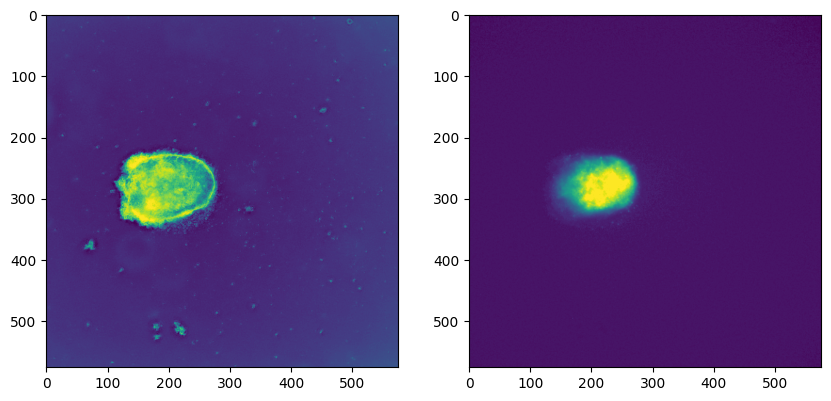

In [8]:
plot_size = 5
plot_images = 2
fig, ax = plt.subplots(1,plot_images,figsize=(plot_images*plot_size,plot_size))

ax[0].imshow(test_image.squeeze(0).numpy()[0])
ax[1].imshow(test_image.squeeze(0).numpy()[1])

In [9]:
model.eval()
result = model(test_image.to(device))[0]
result.shape

torch.Size([1, 2, 576, 576])

In [10]:
result = result.detach().cpu().squeeze().numpy()
result.shape

(2, 576, 576)

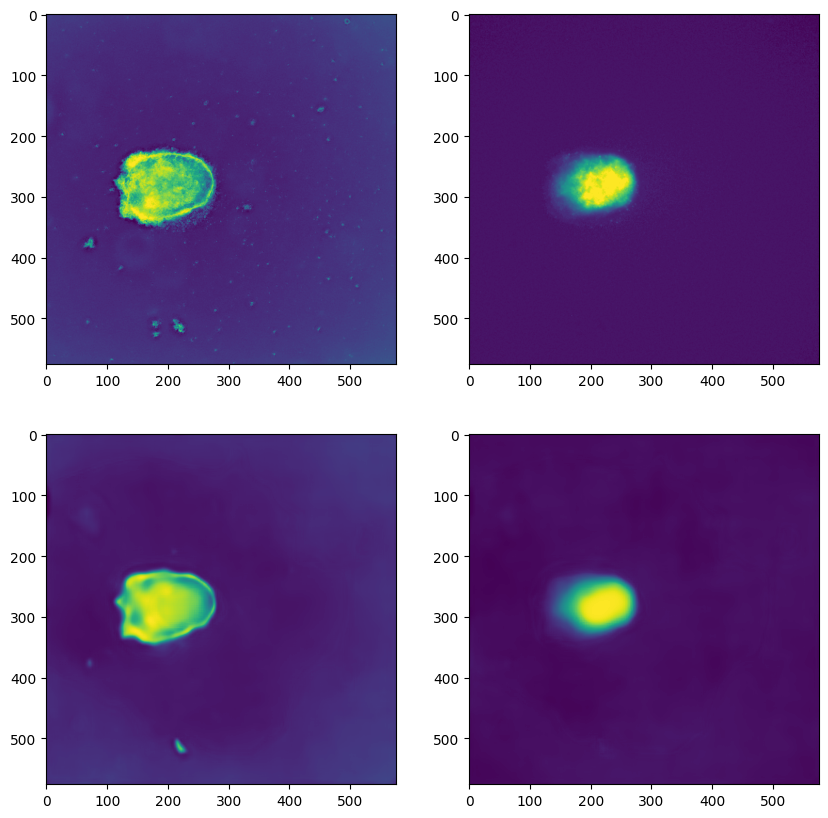

In [11]:
fig, ax = plt.subplots(2,2,figsize=(2*plot_size,2*plot_size))

ax[0,0].imshow(test_image.squeeze(0).numpy()[0])
ax[0,1].imshow(test_image.squeeze(0).numpy()[1])
ax[1,0].imshow(result[0])
ax[1,1].imshow(result[1])

In [14]:
means = []
variances = []
labels = []
for i,first in enumerate(dataloader):
    image, label = first
    _, z, mean, var = model(image.to(device))
    means.append(mean.detach().cpu())
    variances.append(var.detach().cpu())
    labels.append(label[0])


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB. GPU 0 has a total capacity of 14.58 GiB of which 1.62 MiB is free. Process 22708 has 2.23 GiB memory in use. Process 226804 has 10.25 GiB memory in use. Including non-PyTorch memory, this process has 2.10 GiB memory in use. Of the allocated memory 1.81 GiB is allocated by PyTorch, and 175.23 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [13]:
import pandas as pd

dataframe = pd.DataFrame(torch.concat(means,dim=0).numpy(),columns = [f"LD_mu_{i+1}" for i in range(25)])
dataframe

RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [25]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
components = 5
pca_transformer = PCA(n_components = components)
pca_out = pca_transformer.fit_transform(dataframe)
pca_frame = pd.DataFrame(pca_out,columns=[f"PC_{i+1}" for i in range(components)])
pca_frame["Label"] = labels
pca_frame

,PC_1,PC_2,PC_3,PC_4,PC_5,Label
0,0.000071,0.001427,0.001609,-0.000702,0.001500,good
1,0.003269,0.000310,0.001609,-0.000500,0.000067,bad
2,-0.003186,0.000772,0.000079,-0.000600,0.001298,bad
3,0.001459,0.001694,0.000363,0.000061,0.000880,good
4,-0.002833,-0.001700,0.000133,0.002012,0.000254,bad
...,...,...,...,...,...,...
307,0.003294,0.002303,-0.001123,0.001479,-0.001132,good
308,-0.003888,0.001568,-0.002292,0.001633,0.001275,bad
309,0.000808,-0.002186,0.002351,0.000249,0.000161,good
310,0.001114,0.002270,0.000522,0.001687,0.000586,good


<Axes: xlabel='PC_1', ylabel='PC_2'>

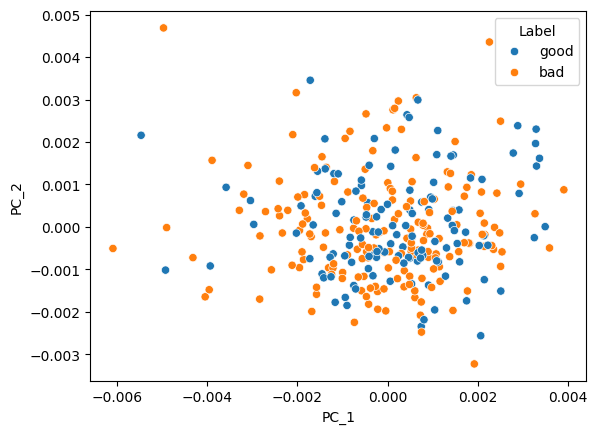

In [29]:
import seaborn as sns

sns.scatterplot(pca_frame,x="PC_1",y="PC_2",hue="Label")

In [30]:
import umap

umap_transformer = umap.UMAP()
umap_out = umap_transformer.fit_transform(dataframe)

umap_df = pd.DataFrame(umap_out,columns=["UMAP_1","UMAP_2"])


/home/S-rs/miniforge3/envs/embed_time/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: Could not interpret value `Label` for `hue`. An entry with this name does not appear in `data`.

<Axes: xlabel='UMAP_1', ylabel='UMAP_2'>

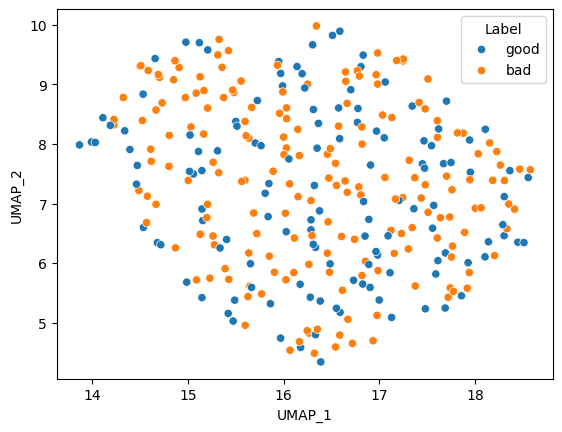

In [31]:
umap_df["Label"] = labels

sns.scatterplot(umap_df,x="UMAP_1",y="UMAP_2",hue="Label")